In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, LassoCV, ElasticNet, PoissonRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import xgboost as xg
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PowerTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.decomposition import PCA
import warnings

#load training and test data
dataset = pd.read_csv('cleanData.csv')

In [3]:
#A function to drop the categorical features from the dataframe
def dropCat_o(data):
    return data.drop(['Area Code','Area Name','parent_name','parent_area'],axis=1)

In [2]:
#A function to drop the categorical features from the dataframe as well as the features where
#large numbers of records had a rate of zero recorded (and so will add to rather than decrease uncertainty in
#modeling)
def dropCat(data):
    return data.drop(['Area Code','Area Name','parent_name','parent_area',
                     'typhoid','measles','hepatitis','STEC','giardia','shigella','listeria','mumps','IMD'],axis=1)

In [4]:
#split into train and test sets
train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state = 43)
train_data.to_csv("communities_training.csv", index=False)
test_data.to_csv("communities_testing.csv", index=False)

In [3]:
train_data = pd.read_csv('communities_training.csv')

In [6]:
#we can see that the scale of the features varies
train_data.head()

,Area Code,Area Name,gen_warts,syphilis,gonorrhea,HIV,herpes,chlamydia,TB,comm_disease_flu,...,back_pain,diabetes,MSK,walking,biking,cancer_death_rate,education,premature,parent_area,parent_name
0,E06000018,Nottingham,72.085861,11.865986,189.559112,3.128908,34.114708,558.591248,11.780366,16.957531,...,10.990853,75.194243,14.427301,20.5955,2.4518,150.377547,44.9835,85.0307,E12000004,East Midlands
1,E07000075,Rochford,36.518425,2.282402,60.483643,0.966366,21.682816,170.038910,1.151375,6.698576,...,11.248205,79.306452,21.799242,9.6329,2.2186,114.962098,61.7464,56.8720,E10000012,Essex
2,E07000163,Craven,24.416616,0.000000,19.184484,0.864394,12.208308,102.898598,1.758726,4.441179,...,10.794776,70.855820,21.694706,16.7428,0.7203,88.008330,65.1079,73.9927,E10000023,North Yorkshire
3,E08000035,Leeds,51.077511,5.758739,117.928955,2.783867,38.934082,530.680298,7.815209,11.805130,...,10.590229,77.169091,16.564005,18.2172,1.2626,133.936918,54.8378,70.0965,E12000003,Yorkshire and The Humber
4,E07000121,Lancaster,53.335495,6.076196,45.909031,0.714595,43.883633,201.864716,3.003898,9.168298,...,10.392378,78.723632,17.454334,15.7211,3.1358,130.391296,58.5099,92.4350,E10000017,Lancashire


In [5]:
#split training data into training and validation sets
X_train,X_validate,Y_train,Y_validate = train_test_split(
    dropCat(train_data).drop('cancer_death_rate',axis=1),
    train_data['cancer_death_rate'],
    test_size = .2, 
    random_state = 43
)

## Define training data

Based on initial exploration of the data, I know that the features have different scales and so need to be rescaled. I also know there is a lot of skew in many of the features, so I want to test a version of the dataset where the skew has been addressed. And since I have 41 predictors, I also want to try subsetting to just the most powerful of those. So below I run through these processes and create versions of the dataset to address them. I can then use these versions when I move on to modeling.

In [6]:
#Create scaled dataset
scaler = StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_validate_scaled=pd.DataFrame(scaler.transform(X_validate),columns=X_validate.columns)

In [7]:
#transform skew using PowerTransformer instead of custom transformer above
pt = PowerTransformer()
X_train_trans = pd.DataFrame(pt.fit_transform(X_train),columns=X_train.columns)
X_validate_trans = pd.DataFrame(pt.transform(X_validate),columns=X_train.columns)

In [8]:
#Create version subsetted to the most predictive features after finding those features via Lasso
lassoCV = LassoCV()
lassoCV.fit(X_train_scaled,Y_train)
lasso_predict = lassoCV.predict(X_validate_scaled)
best_alpha = lassoCV.alpha_
coefs = lassoCV.coef_
table1 = [X_train.columns, coefs]
table1 = pd.DataFrame(table1).T.rename(columns={0:'feature',1:'lasso_score'})
table1['abs_score'] = abs(table1['lasso_score'])
table1 = table1[table1.abs_score>0]
table1.sort_values(by='abs_score', ascending=False,inplace=True)
print('best alpha, scaling only: ',best_alpha)
lasso = Lasso(alpha=best_alpha)
lasso.fit(X_train_scaled,Y_train) 
lasso_predict = lasso.predict(X_validate_scaled)
r2 = r2_score(Y_validate, lasso_predict)
print('r2: ',r2)
print(table1)
#------------------
lassoCVtrans = LassoCV()
lassoCVtrans.fit(X_train_trans,Y_train)
lasso_predict_trans = lassoCVtrans.predict(X_validate_trans)
best_alpha_trans = lassoCVtrans.alpha_
coefs2 = lassoCVtrans.coef_
table2 = [X_train.columns, coefs2]
table2 = pd.DataFrame(table2).T.rename(columns={0:'feature',1:'lasso_score'})
table2['abs_score'] = abs(table2['lasso_score'])
table2 = table2[table2.abs_score>0]
table2.sort_values(by='abs_score', ascending=False,inplace=True)
print('best alpha, scaling plus tranform for skew: ',best_alpha_trans)
lasso_trans = Lasso(alpha=best_alpha_trans)
lasso_trans.fit(X_train_trans,Y_train) 
lasso_predict_trans = lasso_trans.predict(X_validate_trans)
r2_trans = r2_score(Y_validate, lasso_predict_trans)
print('r2: ',r2_trans)
print(table2)

best alpha, scaling only:  0.28236808159511034
r2:  0.6309173202687934
             feature lasso_score abs_score
16    cardiovascular     8.34177   8.34177
17       respiratory     5.38099   5.38099
30         education    -3.40583   3.40583
19        indoor_air    -2.83646   2.83646
5          chlamydia     2.39923   2.39923
6                 TB    -2.07257   2.07257
15      low_birth_wt    -2.01953   2.01953
12          pertusis     1.53905   1.53905
26          diabetes     1.46729   1.46729
22         pollution     -1.4468    1.4468
9         salmonella     1.40147   1.40147
14             noise    -1.33016   1.33016
8        antibiotics     1.20621   1.20621
18      osteoporosis    -1.18098   1.18098
27               MSK    0.944418  0.944418
7   comm_disease_flu    0.877433  0.877433
13            mental    0.779527  0.779527
29            biking    0.745473  0.745473
21           alcohol    0.532981  0.532981
11   cryptosporidium   -0.495398  0.495398
20                RA   -0.

From the above, we can draw 2 conclusions:  
1. There is a subset of the 41 features that appears to hold all of the predictive power.
2. Correcting for skew in the data results in a poorer model.
I'll create a subsetted version of the data (not corrected for skew) to try out in the modelling process along with the full feature set.

In [9]:
#create subset of data using the Lasso-selected features from the transformed dataset
X_train_subset_scaled = X_train_trans[list(table2['feature'])]
X_validate_subset_scaled = X_validate_trans[list(table2['feature'])]

## Modeling

Regresion models

In [12]:
model_types = [LinearRegression(), Ridge(), Lasso(), LassoCV(), ElasticNet(), PoissonRegressor()]

import warnings
warnings.simplefilter('ignore')

models = ['LR scaled','LR subset','LR trans', 
          'Ridge scaled','Ridge subset','Ridge trans',
         'Lasso scaled','Lasso subset','Lasso trans',
         'LassoCV scaled','LassoCV subset','LassoCV trans',
         'EN scaled','EN subset','EN trans',
         'Pois scaled', 'Pois subset', 'Pois trans']
r2s = []
MSEs = []

for model in model_types:
    for dataset in [[X_train_scaled, X_validate_scaled],
                    [X_train_subset_scaled,X_validate_subset_scaled],
                    [X_train_trans,X_validate_trans]]:
        model.fit(dataset[0],Y_train)
        mod_pred = model.predict(dataset[1])
        r2s.append(r2_score(Y_validate, mod_pred))
        MSEs.append(mean_squared_error(Y_validate, mod_pred))

tableData = [models,MSEs,r2s]
regResults = pd.DataFrame(tableData).T
regResults.columns=['model','MSE','r2']

In [13]:
regResults.sort_values(by='r2',ascending=False)

,model,MSE,r2
11,LassoCV trans,138.093,0.65285
16,Pois subset,143.567,0.639089
10,LassoCV subset,143.782,0.638547
4,Ridge subset,145.256,0.634842
17,Pois trans,145.654,0.633842
1,LR subset,146.018,0.632925
9,LassoCV scaled,146.817,0.630917
5,Ridge trans,148.247,0.627322
2,LR trans,149.212,0.624897
7,Lasso subset,149.566,0.624006


XGBoost

In [32]:
def getXGparams(training_X, training_Y, objective='reg:squarederror'):
    param_options = {'max_depth':[2,3,4],
                    'learning_rate': [.17,.13,.1,.05,.02],
                    'gamma': [0,.25,.5]}

    #find best params using 90% of data on each iteration and 50% of cols per tree
    find_best = GridSearchCV(
        estimator = xg.XGBRegressor(objective=objective,
                                    seed = 43,
                                   subsample=0.9,
                                   colsample_bytree=0.5),
        param_grid = param_options,
        cv=3
    )

    find_best.fit(training_X,training_Y)

    return [find_best.best_params_['gamma'],find_best.best_params_['learning_rate'],find_best.best_params_['max_depth']]  

In [33]:
def runXGmodel(gamma, learning_rate, max_depth, training_X, training_Y, validate_X, validate_Y,
              objective='reg:squarederror'):
    xgbModel = xg.XGBRegressor(objective=objective,
                               seed = 43,
                              gamma=gamma,
                              learning_rate=learning_rate,
                              max_depth=max_depth)
    xgbModel.fit(training_X, training_Y)
    pred=xgbModel.predict(validate_X)
    error = mean_squared_error(validate_Y, pred)
    r2 = r2_score(validate_Y,pred)
    return(error, r2)

In [34]:
data_sets = ['reg_scaled','reg_subset+scaled','reg_tranformed+scaled',
             'pois_scaled','pois_subset+scaled','pois_tranformed+scaled']
errors = []
r2s = []
for dataset in [[X_train_scaled, X_validate_scaled,'reg:squarederror'], 
                [X_train_subset_scaled, X_validate_subset_scaled,'reg:squarederror'],
                [X_train_trans, X_validate_trans,'reg:squarederror'],
                [X_train_scaled, X_validate_scaled,'count:poisson'], 
                [X_train_subset_scaled, X_validate_subset_scaled,'count:poisson'],
                [X_train_trans, X_validate_trans,'count:poisson']]:
    gamma, lr, md = getXGparams(dataset[0],Y_train, dataset[2])
    error, r2 = runXGmodel(gamma, lr, md, dataset[0],Y_train, dataset[1],Y_validate, dataset[2])
    errors.append(error)
    r2s.append(r2)
tableXGresults = [data_sets,errors,r2s]
tableXGresults = pd.DataFrame(tableXGresults).T
tableXGresults.columns=['data_set','MSE','r2']

In [35]:
print('XGBoost Model results:')
tableXGresults.sort_values(by='r2',ascending=False)

XGBoost Model results:


,data_set,MSE,r2
2,reg_tranformed+scaled,155.267,0.609675
0,reg_scaled,157.77,0.603384
1,reg_subset+scaled,158.449,0.601676
3,pois_scaled,158.695,0.601056
5,pois_tranformed+scaled,158.969,0.600368
4,pois_subset+scaled,164.381,0.586764


Random forest

In [43]:
def getRFparams(dataset):
    param_options = {'max_depth':[2,3,4,5,6],
                'min_samples_leaf': [2,3,4,5]
                }
    #find best params using 90% of data on each iteration and 50% of cols per tree
    find_best = GridSearchCV(
        estimator = RandomForestRegressor(random_state=43),
        param_grid = param_options,
        cv=3
    )

    find_best.fit(dataset[0],Y_train)
    return [find_best.best_params_['max_depth'],find_best.best_params_['min_samples_leaf']]

In [44]:
def runRFmodel(max_depth, min_samples_leaf, dataset):
    regr = RandomForestRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=43)
    regr.fit(dataset[0], Y_train)

    regr_predict = regr.predict(dataset[1])
    error = mean_squared_error(Y_validate, regr_predict)
    r2 = r2_score(Y_validate, regr_predict)
    return [error, r2]

In [45]:
data_sets = ['scaled','subset+scaled','trans+scaled']
errors = []
r2s = []
for dataset in [[X_train_scaled, X_validate_scaled], [X_train_subset_scaled, X_validate_subset_scaled],
               [X_train_trans, X_validate_trans]]:
    max_depth, min_samples_leaf = getRFparams(dataset)
    error, r2 = runRFmodel(max_depth, min_samples_leaf, dataset)
    errors.append(error)
    r2s.append(r2)
tableRFresults = [data_sets,errors,r2s]
tableRFresults = pd.DataFrame(tableRFresults).T
tableRFresults.columns=['data_set','MSE','r2']

In [46]:
print('Random Forest Model results:')
tableRFresults.sort_values(by='r2',ascending=False)

Random Forest Model results:


,data_set,MSE,r2
1,subset+scaled,161.927,0.592932
2,trans+scaled,164.129,0.587398
0,scaled,164.147,0.587351


To this point, the best performing model is the LassoCV regression model, which has transformed features and an r-squared of ~0.65.  

Now I'll look into principal component analysis to see if I can improve predictive strength through dimensionality reduction.

PCA

Regression models with PCA

In [66]:
model_types = [LinearRegression(), Ridge(), Lasso(), LassoCV(), ElasticNet(), PoissonRegressor()]

In [74]:
#function to run PCA across several models and provide the score, given a training and validation set

warnings.simplefilter('ignore')

def getPCAresults(dataset):
    models = []
    r2s = []
    MSEs = []
    pca = PCA(n_components=.95)

    for model in model_types:
        pipe = make_pipeline(pca, model)
        models.append(str(model)[:-2])
        #pipe.fit(X_train_subset_scaled,Y_train)
        #mod_pred = pipe.predict(X_validate_subset_scaled)
        pipe.fit(dataset[0], Y_train)
        mod_pred = pipe.predict(dataset[1])
        r2s.append(r2_score(Y_validate, mod_pred))
        MSEs.append(mean_squared_error(Y_validate, mod_pred))

    tableData = [models,MSEs,r2s]
    pcaRegResults = pd.DataFrame(tableData).T
    pcaRegResults.columns=['model','MSE','r2']
    return pcaRegResults.sort_values(by='r2',ascending=False)

In [75]:
print('Scaled data set results:')
getPCAresults([X_train_scaled, X_validate_scaled])

Scaled data set results:


,model,MSE,r2
3,LassoCV,155.162,0.60994
1,Ridge,156.421,0.606774
0,LinearRegression,156.532,0.606495
2,Lasso,159.86,0.598129
5,PoissonRegressor,160.682,0.596061
4,ElasticNet,167.171,0.57975


In [76]:
print('Transformed and scaled data set results:')
getPCAresults([X_train_trans, X_validate_trans])

Transformed and scaled data set results:


,model,MSE,r2
5,PoissonRegressor,154.425,0.611791
3,LassoCV,155.659,0.608691
1,Ridge,156.249,0.607206
0,LinearRegression,156.56,0.606424
4,ElasticNet,167.687,0.578452
2,Lasso,169.441,0.574044


In [77]:
print('Subsetted, transformed, and scaled results:')
getPCAresults([X_train_subset_scaled, X_validate_subset_scaled])

Subsetted, transformed, and scaled results:


,model,MSE,r2
5,PoissonRegressor,140.636,0.646456
1,Ridge,141.374,0.644601
0,LinearRegression,141.605,0.64402
3,LassoCV,144.497,0.63675
2,Lasso,155.099,0.610097
4,ElasticNet,159.098,0.600043


The transformed and the subset/transformed datasets are producing the best performing models.
So I'll focus on those.

XGBoost with PCA

In [100]:
#function to find best parameters
def getXGPCAparams(dataset):
    pca = PCA(n_components=.95)
    param_options = {'max_depth':[2,3,4],
                    'learning_rate': [.15,.1,.09,.08],
                    'gamma': [0,.2,.35,.5]}

    #find best params using 90% of data on each iteration and 50% of cols per tree
    find_bestPCA = GridSearchCV(
        estimator = xg.XGBRegressor(seed = 43,
                                   subsample=0.9,
                                   colsample_bytree=0.5),
        param_grid = param_options,
        cv=3
    )

    pipe = make_pipeline(pca, find_bestPCA)
    pipe.fit(dataset[0],Y_train)

    #print(pipe.named_steps['gridsearchcv'].best_params_)
    return [pipe.named_steps['gridsearchcv'].best_params_['gamma'],
           pipe.named_steps['gridsearchcv'].best_params_['learning_rate'],
           pipe.named_steps['gridsearchcv'].best_params_['max_depth']]

In [101]:
#function to run XGBoost with PCA given dataset and parameters
def getXgbModelPCA(dataset,gamma,learning_rate,max_depth):
    xgbModelPCA = xg.XGBRegressor(seed = 43,
                              gamma=gamma,
                              learning_rate=learning_rate,
                              max_depth=max_depth)

    pipe = make_pipeline(pca, xgbModelPCA)
    pipe.fit(dataset[0],Y_train)
    pred=pipe.predict(dataset[1])
    error = mean_squared_error(Y_validate, pred)
    r2 = r2_score(Y_validate,pred)
    return [error, r2]

In [104]:
#Run each of the datasets through the above function
for dataset in [[X_train_trans, X_validate_trans, 'Transformed'],
                [X_train_subset_scaled,X_validate_subset_scaled,'Subset']]:
    print('Results for %s set'%dataset[2])
    g, lr, md = getXGPCAparams(dataset)
    error, r2 = getXgbModelPCA(dataset, g, lr, md)
    print('error: ', error, 'r2: ', r2)

Results for Transformed set
error:  164.99816765040575 r2:  0.5852119675515963
Results for Subset set
error:  160.20537465327916 r2:  0.5972605448510893


Random forest with PCA

In [122]:
#function to find best parameters
def rvPCAparams(dataset):
    pca = PCA(n_components=.95)
    param_options = {'max_depth':[2,3,4,5,6],
                    'min_samples_leaf': [2,3]
                    }

    #find best params using 90% of data on each iteration and 50% of cols per tree
    find_bestPCA = GridSearchCV(
        estimator = RandomForestRegressor(random_state=43),
        param_grid = param_options,
        cv=3
    )

    pipe = make_pipeline(pca, find_bestPCA)
    pipe.fit(dataset[0],Y_train)

    return [pipe.named_steps['gridsearchcv'].best_params_['max_depth'],
            pipe.named_steps['gridsearchcv'].best_params_['min_samples_leaf']]

In [15]:
#function to run a random forest model with PCA given a dataset and parameters
def getRFpcaModel(dataset, md, msl):
    regr_subset = RandomForestRegressor(max_depth=md, min_samples_leaf=msl, random_state=43)
    pipe = make_pipeline(pca, regr_subset)
    pipe.fit(dataset[0],Y_train)
    regr_predict = pipe.predict(dataset[1])
    error2 = mean_squared_error(Y_validate, regr_predict)
    r2 = r2_score(Y_validate, regr_predict)
    return [error2, r2]

In [124]:
#Run the datasets through the above function
for dataset in [[X_train_trans, X_validate_trans, 'Transformed'],
                [X_train_subset_scaled,X_validate_subset_scaled,'Subset']]:
    print('Results for %s set'%dataset[2])
    md, msl = rvPCAparams(dataset)
    error, r2 = getRFpcaModel(dataset, md, msl)
    print('error: ', error, 'r2: ', r2)

Results for Transformed set
error:  168.3157722632574 r2:  0.5768718586315861
Results for Subset set
error:  123.80817675029209 r2:  0.6887592706842307


In [172]:
#keep record of parameters for best model
print(md, msl)

6 2


The best model overall thus far is Random Forest with PCA using the subsetting dataset (which is also transformed).
It yields an r-squared of ~0.69.  
The second best model is the LassoCV on the transformed (not subsetted) dataset, with an r-squared of ~0.65.

In [125]:
#get number of features in subsetted version
len(X_train_subset_scaled.columns)

24

In [126]:
#get number of features in non-subsetted version
len(X_train_trans.columns)

32

Tensorflow

In [142]:
#function to find the best paramaters for a tensorflow model
def buildModelTF(hp):
    model = keras.Sequential()
    model.add(layers.Dense(hp.Choice('units1',[2,4,6]), input_dim=32, activation="relu"))
    for i in range(2):
        model.add(layers.Dense(hp.Choice('units2',[50,150,200]),activation="relu"))
    model.add(layers.Dense(1))
    keras.optimizers.Adam(learning_rate=hp.Choice('units3',[.0006,.00006,]))
    model.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])
    return model

In [143]:
#set early stopping condition
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [145]:
#run the tuner to find the best model
tuner = kt.RandomSearch(buildModelTF,
                     objective='val_mse',
                     max_trials=30,
                        executions_per_trial=4,
                    overwrite = False,
                    directory='TfTuner'
                    )
tuner.search(X_train_trans, Y_train, epochs=350, batch_size=20,validation_data=(X_validate_trans, Y_validate))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 01m 02s]
val_mse: 238.29383087158203

Best val_mse So Far: 129.1446647644043
Total elapsed time: 00h 10m 48s

Search: Running Trial #11

Hyperparameter    |Value             |Best Value So Far 
units1            |6                 |2                 
units2            |50                |50                
units3            |6e-05             |6e-05             

Epoch 1/350
10/10 [==============================] - 0s 14ms/step - loss: 16050.8418 - mse: 16050.8418 - val_loss: 16045.7705 - val_mse: 16045.7705
Epoch 2/350
10/10 [==============================] - 0s 4ms/step - loss: 15949.0781 - mse: 15949.0781 - val_loss: 15938.3242 - val_mse: 15938.3242
Epoch 3/350
10/10 [==============================] - 0s 4ms/step - loss: 15838.9268 - mse: 15838.9268 - val_loss: 15797.0000 - val_mse: 15796.9971
Epoch 4/350
10/10 [==============================] - 0s 6ms/step - loss: 15680.5801 - mse: 15680.5801 - val_loss: 15592.4990 - val_mse: 15592.4990
Epoch 5/350
10/10 [===

10/10 [==============================] - 0s 4ms/step - loss: 472.0287 - mse: 472.0287 - val_loss: 744.1243 - val_mse: 744.1243
Epoch 55/350
10/10 [==============================] - 0s 4ms/step - loss: 458.9284 - mse: 458.9284 - val_loss: 724.9468 - val_mse: 724.9468
Epoch 56/350
10/10 [==============================] - 0s 4ms/step - loss: 449.0683 - mse: 449.0683 - val_loss: 708.7001 - val_mse: 708.7001
Epoch 57/350
10/10 [==============================] - 0s 5ms/step - loss: 437.6796 - mse: 437.6796 - val_loss: 696.6753 - val_mse: 696.6753
Epoch 58/350
10/10 [==============================] - 0s 4ms/step - loss: 426.1929 - mse: 426.1929 - val_loss: 671.7593 - val_mse: 671.7593
Epoch 59/350
10/10 [==============================] - 0s 3ms/step - loss: 415.1340 - mse: 415.1340 - val_loss: 656.2871 - val_mse: 656.2871
Epoch 60/350
10/10 [==============================] - 0s 4ms/step - loss: 403.2608 - mse: 403.2608 - val_loss: 639.8084 - val_mse: 639.8084
Epoch 61/350
10/10 [=============

10/10 [==============================] - 0s 4ms/step - loss: 169.6520 - mse: 169.6520 - val_loss: 300.5250 - val_mse: 300.5250
Epoch 113/350
10/10 [==============================] - 0s 3ms/step - loss: 168.8745 - mse: 168.8745 - val_loss: 300.2885 - val_mse: 300.2885
Epoch 114/350
10/10 [==============================] - 0s 4ms/step - loss: 165.8292 - mse: 165.8292 - val_loss: 295.2478 - val_mse: 295.2478
Epoch 115/350
10/10 [==============================] - 0s 4ms/step - loss: 164.6354 - mse: 164.6354 - val_loss: 292.6971 - val_mse: 292.6971
Epoch 116/350
10/10 [==============================] - 0s 4ms/step - loss: 163.0782 - mse: 163.0782 - val_loss: 291.5854 - val_mse: 291.5854
Epoch 117/350
10/10 [==============================] - 0s 4ms/step - loss: 161.3363 - mse: 161.3363 - val_loss: 289.0187 - val_mse: 289.0187
Epoch 118/350
10/10 [==============================] - 0s 3ms/step - loss: 159.6923 - mse: 159.6923 - val_loss: 283.9474 - val_mse: 283.9474
Epoch 119/350
10/10 [======

10/10 [==============================] - 0s 4ms/step - loss: 110.1328 - mse: 110.1328 - val_loss: 201.8722 - val_mse: 201.8722
Epoch 171/350
10/10 [==============================] - 0s 3ms/step - loss: 108.2668 - mse: 108.2668 - val_loss: 199.9619 - val_mse: 199.9619
Epoch 172/350
10/10 [==============================] - 0s 5ms/step - loss: 108.4329 - mse: 108.4329 - val_loss: 198.6420 - val_mse: 198.6420
Epoch 173/350
10/10 [==============================] - 0s 4ms/step - loss: 108.1377 - mse: 108.1377 - val_loss: 198.5297 - val_mse: 198.5297
Epoch 174/350
10/10 [==============================] - 0s 5ms/step - loss: 108.3929 - mse: 108.3929 - val_loss: 196.0857 - val_mse: 196.0857
Epoch 175/350
10/10 [==============================] - 0s 4ms/step - loss: 107.9714 - mse: 107.9714 - val_loss: 199.4732 - val_mse: 199.4731
Epoch 176/350
10/10 [==============================] - 0s 4ms/step - loss: 105.4060 - mse: 105.4060 - val_loss: 194.8321 - val_mse: 194.8321
Epoch 177/350
10/10 [======

10/10 [==============================] - 0s 3ms/step - loss: 89.1579 - mse: 89.1579 - val_loss: 172.3236 - val_mse: 172.3236
Epoch 229/350
10/10 [==============================] - 0s 4ms/step - loss: 89.0707 - mse: 89.0707 - val_loss: 170.4421 - val_mse: 170.4421
Epoch 230/350
10/10 [==============================] - 0s 4ms/step - loss: 88.2877 - mse: 88.2877 - val_loss: 171.1669 - val_mse: 171.1669
Epoch 231/350
10/10 [==============================] - 0s 4ms/step - loss: 87.9603 - mse: 87.9603 - val_loss: 173.9234 - val_mse: 173.9234
Epoch 232/350
10/10 [==============================] - 0s 4ms/step - loss: 87.4901 - mse: 87.4901 - val_loss: 172.0799 - val_mse: 172.0799
Epoch 233/350
10/10 [==============================] - 0s 3ms/step - loss: 86.8729 - mse: 86.8729 - val_loss: 169.9355 - val_mse: 169.9356
Epoch 234/350
10/10 [==============================] - 0s 4ms/step - loss: 86.8548 - mse: 86.8548 - val_loss: 170.9018 - val_mse: 170.9018
Epoch 235/350
10/10 [====================

10/10 [==============================] - 0s 4ms/step - loss: 75.7112 - mse: 75.7112 - val_loss: 166.5440 - val_mse: 166.5440
Epoch 287/350
10/10 [==============================] - 0s 4ms/step - loss: 75.5133 - mse: 75.5133 - val_loss: 165.3074 - val_mse: 165.3074
Epoch 288/350
10/10 [==============================] - 0s 3ms/step - loss: 75.2385 - mse: 75.2385 - val_loss: 164.4405 - val_mse: 164.4405
Epoch 289/350
10/10 [==============================] - 0s 3ms/step - loss: 75.2793 - mse: 75.2793 - val_loss: 166.5027 - val_mse: 166.5027
Epoch 290/350
10/10 [==============================] - 0s 3ms/step - loss: 76.4355 - mse: 76.4355 - val_loss: 166.4362 - val_mse: 166.4362
Epoch 291/350
10/10 [==============================] - 0s 4ms/step - loss: 75.6622 - mse: 75.6622 - val_loss: 164.3484 - val_mse: 164.3484
Epoch 292/350
10/10 [==============================] - 0s 4ms/step - loss: 74.1428 - mse: 74.1428 - val_loss: 167.6345 - val_mse: 167.6345
Epoch 293/350
10/10 [====================

Epoch 345/350
10/10 [==============================] - 0s 3ms/step - loss: 65.1192 - mse: 65.1192 - val_loss: 164.1487 - val_mse: 164.1487
Epoch 346/350
10/10 [==============================] - 0s 4ms/step - loss: 65.3622 - mse: 65.3622 - val_loss: 164.1676 - val_mse: 164.1676
Epoch 347/350
10/10 [==============================] - 0s 3ms/step - loss: 65.0129 - mse: 65.0129 - val_loss: 165.0635 - val_mse: 165.0635
Epoch 348/350
10/10 [==============================] - 0s 4ms/step - loss: 64.5397 - mse: 64.5397 - val_loss: 164.5448 - val_mse: 164.5448
Epoch 349/350
10/10 [==============================] - 0s 4ms/step - loss: 64.7102 - mse: 64.7102 - val_loss: 165.1895 - val_mse: 165.1895
Epoch 350/350
10/10 [==============================] - 0s 4ms/step - loss: 64.4426 - mse: 64.4426 - val_loss: 163.8446 - val_mse: 163.8446
Epoch 1/350
10/10 [==============================] - 0s 16ms/step - loss: 16082.3857 - mse: 16082.3857 - val_loss: 16060.8018 - val_mse: 16060.8018
Epoch 2/350
10/10 

10/10 [==============================] - 0s 4ms/step - loss: 566.7900 - mse: 566.7900 - val_loss: 852.4362 - val_mse: 852.4362
Epoch 53/350
10/10 [==============================] - 0s 4ms/step - loss: 549.6546 - mse: 549.6546 - val_loss: 853.6115 - val_mse: 853.6115
Epoch 54/350
10/10 [==============================] - 0s 4ms/step - loss: 532.6443 - mse: 532.6444 - val_loss: 829.5773 - val_mse: 829.5773
Epoch 55/350
10/10 [==============================] - 0s 4ms/step - loss: 519.0925 - mse: 519.0925 - val_loss: 809.7578 - val_mse: 809.7578
Epoch 56/350
10/10 [==============================] - 0s 3ms/step - loss: 507.4750 - mse: 507.4750 - val_loss: 794.5438 - val_mse: 794.5438
Epoch 57/350
10/10 [==============================] - 0s 3ms/step - loss: 494.7922 - mse: 494.7922 - val_loss: 793.0588 - val_mse: 793.0588
Epoch 58/350
10/10 [==============================] - 0s 3ms/step - loss: 481.6591 - mse: 481.6591 - val_loss: 782.9697 - val_mse: 782.9697
Epoch 59/350
10/10 [=============

10/10 [==============================] - 0s 3ms/step - loss: 197.0411 - mse: 197.0412 - val_loss: 421.1100 - val_mse: 421.1100
Epoch 110/350
10/10 [==============================] - 0s 5ms/step - loss: 194.8057 - mse: 194.8057 - val_loss: 422.4283 - val_mse: 422.4283
Epoch 111/350
10/10 [==============================] - 0s 4ms/step - loss: 192.6754 - mse: 192.6754 - val_loss: 417.5183 - val_mse: 417.5183
Epoch 112/350
10/10 [==============================] - 0s 3ms/step - loss: 189.8822 - mse: 189.8822 - val_loss: 412.8363 - val_mse: 412.8363
Epoch 113/350
10/10 [==============================] - 0s 4ms/step - loss: 187.1240 - mse: 187.1240 - val_loss: 410.2346 - val_mse: 410.2346
Epoch 114/350
10/10 [==============================] - 0s 4ms/step - loss: 185.7592 - mse: 185.7592 - val_loss: 410.9656 - val_mse: 410.9656
Epoch 115/350
10/10 [==============================] - 0s 4ms/step - loss: 182.3022 - mse: 182.3022 - val_loss: 403.6392 - val_mse: 403.6392
Epoch 116/350
10/10 [======

10/10 [==============================] - 0s 7ms/step - loss: 115.8548 - mse: 115.8548 - val_loss: 292.1761 - val_mse: 292.1761
Epoch 168/350
10/10 [==============================] - 0s 7ms/step - loss: 112.3639 - mse: 112.3639 - val_loss: 296.8695 - val_mse: 296.8695
Epoch 169/350
10/10 [==============================] - 0s 8ms/step - loss: 111.9463 - mse: 111.9463 - val_loss: 293.9308 - val_mse: 293.9308
Epoch 170/350
10/10 [==============================] - 0s 8ms/step - loss: 110.9626 - mse: 110.9626 - val_loss: 293.4445 - val_mse: 293.4445
Epoch 171/350
10/10 [==============================] - 0s 8ms/step - loss: 110.5792 - mse: 110.5792 - val_loss: 293.2411 - val_mse: 293.2411
Epoch 172/350
10/10 [==============================] - 0s 8ms/step - loss: 110.2050 - mse: 110.2050 - val_loss: 291.6106 - val_mse: 291.6106
Epoch 173/350
10/10 [==============================] - 0s 8ms/step - loss: 108.7127 - mse: 108.7127 - val_loss: 291.6069 - val_mse: 291.6069
Epoch 174/350
10/10 [======

Epoch 226/350
10/10 [==============================] - 0s 8ms/step - loss: 83.8216 - mse: 83.8216 - val_loss: 257.5805 - val_mse: 257.5805
Epoch 227/350
10/10 [==============================] - 0s 7ms/step - loss: 83.6975 - mse: 83.6975 - val_loss: 260.2350 - val_mse: 260.2350
Epoch 228/350
10/10 [==============================] - 0s 7ms/step - loss: 84.8991 - mse: 84.8991 - val_loss: 254.9622 - val_mse: 254.9622
Epoch 229/350
10/10 [==============================] - 0s 7ms/step - loss: 82.9376 - mse: 82.9376 - val_loss: 258.7854 - val_mse: 258.7854
Epoch 230/350
10/10 [==============================] - 0s 7ms/step - loss: 83.3175 - mse: 83.3175 - val_loss: 260.7493 - val_mse: 260.7493
Epoch 231/350
10/10 [==============================] - 0s 6ms/step - loss: 82.5286 - mse: 82.5286 - val_loss: 257.0343 - val_mse: 257.0343
Epoch 232/350
10/10 [==============================] - 0s 6ms/step - loss: 82.0930 - mse: 82.0930 - val_loss: 258.0028 - val_mse: 258.0028
Epoch 233/350
10/10 [======

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000002A27FC43048>
Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\data\ops\iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\ProgramData\Miniconda3\lib\site-packages\tensorflow\python\ops\gen_dataset_ops.py", line 1263, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 265/350
10/10 [==============================] - 0s 6ms/step - loss: 73.6698 - mse: 73.6698 - val_loss: 252.3033 - val_mse: 252.3033
Epoch 266/350
10/10 [==============================] - 0s 5ms/step - loss: 73.5537 - mse: 73.5537 - val_loss: 249.4819 - val_mse: 249.4819
Epoch 267/350
10/10 [==============================] - 0s 5ms/step - loss: 74.9207 - mse: 74.9207 - val_loss: 250.2741 - val_mse: 250.2741
Epoch 268/350
10/10 [==============================] - 0s 5ms/step - loss: 73.5815 - mse: 73.5815 - val_loss: 248.5703 - val_mse: 248.5703
Epoch 269/350
10/10 [==============================] - 0s 5ms/step - loss: 72.4200 - mse: 72.4200 - val_loss: 248.4611 - val_mse: 248.4611
Epoch 270/350
10/10 [==============================] - 0s 6ms/step - loss: 73.3535 - mse: 73.3535 - val_loss: 248.9030 - val_mse: 248.9030
Epoch 271/350
10/10 [==============================] - 0s 5ms/step - loss: 74.2251 - mse: 74.2251 - val_loss: 247.4475 - val_mse: 247.4475
Epoch 272/350
10/10 [======

Epoch 324/350
10/10 [==============================] - 0s 5ms/step - loss: 61.6015 - mse: 61.6015 - val_loss: 245.3440 - val_mse: 245.3440
Epoch 325/350
10/10 [==============================] - 0s 5ms/step - loss: 61.1074 - mse: 61.1074 - val_loss: 245.7842 - val_mse: 245.7842
Epoch 326/350
10/10 [==============================] - 0s 5ms/step - loss: 60.9838 - mse: 60.9838 - val_loss: 245.6238 - val_mse: 245.6238
Epoch 327/350
10/10 [==============================] - 0s 5ms/step - loss: 61.8882 - mse: 61.8882 - val_loss: 243.4550 - val_mse: 243.4550
Epoch 328/350
10/10 [==============================] - 0s 5ms/step - loss: 61.2100 - mse: 61.2100 - val_loss: 244.2316 - val_mse: 244.2316
Epoch 329/350
10/10 [==============================] - 0s 6ms/step - loss: 61.9576 - mse: 61.9576 - val_loss: 245.8186 - val_mse: 245.8186
Epoch 330/350
10/10 [==============================] - 0s 6ms/step - loss: 60.9341 - mse: 60.9341 - val_loss: 246.5480 - val_mse: 246.5480
Epoch 331/350
10/10 [======

10/10 [==============================] - 0s 5ms/step - loss: 1169.1429 - mse: 1169.1429 - val_loss: 1560.9525 - val_mse: 1560.9525
Epoch 32/350
10/10 [==============================] - 0s 6ms/step - loss: 1126.3599 - mse: 1126.3599 - val_loss: 1507.8232 - val_mse: 1507.8232
Epoch 33/350
10/10 [==============================] - 0s 6ms/step - loss: 1088.0271 - mse: 1088.0271 - val_loss: 1439.3575 - val_mse: 1439.3575
Epoch 34/350
10/10 [==============================] - 0s 6ms/step - loss: 1053.7639 - mse: 1053.7639 - val_loss: 1418.9716 - val_mse: 1418.9716
Epoch 35/350
10/10 [==============================] - 0s 6ms/step - loss: 1013.0856 - mse: 1013.0856 - val_loss: 1373.7552 - val_mse: 1373.7552
Epoch 36/350
10/10 [==============================] - 0s 5ms/step - loss: 977.3765 - mse: 977.3765 - val_loss: 1339.5614 - val_mse: 1339.5614
Epoch 37/350
10/10 [==============================] - 0s 5ms/step - loss: 940.3493 - mse: 940.3493 - val_loss: 1303.8651 - val_mse: 1303.8651
Epoch 38/

KeyboardInterrupt: 

After trialing both the transformed and the subsetted datasets for best parameters and validating, I find the subsetted dataset to be the one that consistently performs best.

In [164]:
#run final check with the selected parameters
modelTF = keras.Sequential()
modelTF.add(layers.Dense(2, input_dim=24, activation="relu"))
modelTF.add(layers.Dense(150,activation="relu"))
modelTF.add(layers.Dense(150, activation="relu"))
modelTF.add(layers.Dense(1))
keras.optimizers.Adam(learning_rate=0.00006)
modelTF.compile(loss='mean_squared_error',optimizer='adam',metrics=['mse'])

In [165]:
#set early stopping condition
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [166]:
#Run model with best parameters
history = modelTF.fit(X_train_subset_scaled, Y_train, epochs=510, batch_size=20, validation_data=(X_validate_subset_scaled, Y_validate), callbacks = [early_stopping_cb])

Epoch 1/510
10/10 [==============================] - 1s 31ms/step - loss: 15978.9961 - mse: 15978.9961 - val_loss: 15965.3945 - val_mse: 15965.3945
Epoch 2/510
10/10 [==============================] - 0s 5ms/step - loss: 15822.0049 - mse: 15822.0049 - val_loss: 15781.9912 - val_mse: 15781.9893
Epoch 3/510
10/10 [==============================] - 0s 6ms/step - loss: 15563.8506 - mse: 15563.8506 - val_loss: 15464.2266 - val_mse: 15464.2266
Epoch 4/510
10/10 [==============================] - 0s 6ms/step - loss: 15090.7539 - mse: 15090.7539 - val_loss: 14948.2109 - val_mse: 14948.2109
Epoch 5/510
10/10 [==============================] - 0s 5ms/step - loss: 14364.8105 - mse: 14364.8105 - val_loss: 14136.2744 - val_mse: 14136.2744
Epoch 6/510
10/10 [==============================] - 0s 6ms/step - loss: 13227.4775 - mse: 13227.4775 - val_loss: 12988.2305 - val_mse: 12988.2305
Epoch 7/510
10/10 [==============================] - 0s 6ms/step - loss: 11657.1475 - mse: 11657.1475 - val_loss: 115

Epoch 59/510
10/10 [==============================] - 0s 6ms/step - loss: 240.2986 - mse: 240.2986 - val_loss: 299.7750 - val_mse: 299.7750
Epoch 60/510
10/10 [==============================] - 0s 6ms/step - loss: 237.3190 - mse: 237.3190 - val_loss: 293.8994 - val_mse: 293.8994
Epoch 61/510
10/10 [==============================] - 0s 5ms/step - loss: 235.6189 - mse: 235.6189 - val_loss: 293.4165 - val_mse: 293.4165
Epoch 62/510
10/10 [==============================] - 0s 6ms/step - loss: 233.5053 - mse: 233.5053 - val_loss: 293.0732 - val_mse: 293.0732
Epoch 63/510
10/10 [==============================] - 0s 6ms/step - loss: 233.8002 - mse: 233.8002 - val_loss: 293.0688 - val_mse: 293.0688
Epoch 64/510
10/10 [==============================] - 0s 6ms/step - loss: 232.3240 - mse: 232.3240 - val_loss: 288.8232 - val_mse: 288.8232
Epoch 65/510
10/10 [==============================] - 0s 6ms/step - loss: 231.3223 - mse: 231.3223 - val_loss: 288.1298 - val_mse: 288.1298
Epoch 66/510
10/10 [

10/10 [==============================] - 0s 5ms/step - loss: 198.2262 - mse: 198.2262 - val_loss: 237.9437 - val_mse: 237.9437
Epoch 118/510
10/10 [==============================] - 0s 5ms/step - loss: 197.1653 - mse: 197.1653 - val_loss: 234.7999 - val_mse: 234.7999
Epoch 119/510
10/10 [==============================] - 0s 5ms/step - loss: 196.8302 - mse: 196.8302 - val_loss: 232.2521 - val_mse: 232.2521
Epoch 120/510
10/10 [==============================] - 0s 6ms/step - loss: 196.8268 - mse: 196.8268 - val_loss: 236.0335 - val_mse: 236.0335
Epoch 121/510
10/10 [==============================] - 0s 6ms/step - loss: 201.0169 - mse: 201.0169 - val_loss: 230.1418 - val_mse: 230.1417
Epoch 122/510
10/10 [==============================] - 0s 5ms/step - loss: 204.6300 - mse: 204.6300 - val_loss: 242.2093 - val_mse: 242.2093
Epoch 123/510
10/10 [==============================] - 0s 6ms/step - loss: 196.0078 - mse: 196.0078 - val_loss: 227.2596 - val_mse: 227.2596
Epoch 124/510
10/10 [======

10/10 [==============================] - 0s 7ms/step - loss: 174.8545 - mse: 174.8545 - val_loss: 202.4416 - val_mse: 202.4416
Epoch 176/510
10/10 [==============================] - 0s 7ms/step - loss: 173.8050 - mse: 173.8050 - val_loss: 196.0332 - val_mse: 196.0332
Epoch 177/510
10/10 [==============================] - 0s 7ms/step - loss: 172.3848 - mse: 172.3848 - val_loss: 201.3312 - val_mse: 201.3312
Epoch 178/510
10/10 [==============================] - 0s 7ms/step - loss: 173.1829 - mse: 173.1829 - val_loss: 199.9764 - val_mse: 199.9764
Epoch 179/510
10/10 [==============================] - 0s 7ms/step - loss: 171.9121 - mse: 171.9121 - val_loss: 196.2305 - val_mse: 196.2305
Epoch 180/510
10/10 [==============================] - 0s 7ms/step - loss: 174.5335 - mse: 174.5335 - val_loss: 198.3836 - val_mse: 198.3836
Epoch 181/510
10/10 [==============================] - 0s 7ms/step - loss: 173.5177 - mse: 173.5177 - val_loss: 193.7362 - val_mse: 193.7362
Epoch 182/510
10/10 [======

10/10 [==============================] - 0s 7ms/step - loss: 152.5548 - mse: 152.5548 - val_loss: 175.5666 - val_mse: 175.5666
Epoch 234/510
10/10 [==============================] - 0s 7ms/step - loss: 153.1941 - mse: 153.1941 - val_loss: 174.9489 - val_mse: 174.9489
Epoch 235/510
10/10 [==============================] - 0s 7ms/step - loss: 152.4550 - mse: 152.4550 - val_loss: 174.5501 - val_mse: 174.5501
Epoch 236/510
10/10 [==============================] - 0s 8ms/step - loss: 153.3540 - mse: 153.3540 - val_loss: 172.9668 - val_mse: 172.9668
Epoch 237/510
10/10 [==============================] - 0s 7ms/step - loss: 151.6102 - mse: 151.6102 - val_loss: 172.5341 - val_mse: 172.5341
Epoch 238/510
10/10 [==============================] - 0s 8ms/step - loss: 150.6917 - mse: 150.6917 - val_loss: 171.1591 - val_mse: 171.1591
Epoch 239/510
10/10 [==============================] - 0s 8ms/step - loss: 150.2849 - mse: 150.2849 - val_loss: 172.8365 - val_mse: 172.8365
Epoch 240/510
10/10 [======

10/10 [==============================] - 0s 5ms/step - loss: 131.4955 - mse: 131.4955 - val_loss: 151.3620 - val_mse: 151.3620
Epoch 292/510
10/10 [==============================] - 0s 6ms/step - loss: 130.5349 - mse: 130.5349 - val_loss: 150.3523 - val_mse: 150.3523
Epoch 293/510
10/10 [==============================] - 0s 6ms/step - loss: 134.6658 - mse: 134.6658 - val_loss: 150.3656 - val_mse: 150.3656
Epoch 294/510
10/10 [==============================] - 0s 5ms/step - loss: 132.4277 - mse: 132.4277 - val_loss: 149.6945 - val_mse: 149.6945
Epoch 295/510
10/10 [==============================] - 0s 7ms/step - loss: 132.4461 - mse: 132.4461 - val_loss: 152.0261 - val_mse: 152.0261
Epoch 296/510
10/10 [==============================] - 0s 7ms/step - loss: 132.9429 - mse: 132.9429 - val_loss: 148.9602 - val_mse: 148.9602
Epoch 297/510
10/10 [==============================] - 0s 7ms/step - loss: 129.5070 - mse: 129.5070 - val_loss: 149.8929 - val_mse: 149.8929
Epoch 298/510
10/10 [======

10/10 [==============================] - 0s 6ms/step - loss: 124.1995 - mse: 124.1995 - val_loss: 136.4140 - val_mse: 136.4140
Epoch 350/510
10/10 [==============================] - 0s 5ms/step - loss: 122.3655 - mse: 122.3655 - val_loss: 136.5881 - val_mse: 136.5881
Epoch 351/510
10/10 [==============================] - 0s 6ms/step - loss: 123.7723 - mse: 123.7723 - val_loss: 138.1859 - val_mse: 138.1859
Epoch 352/510
10/10 [==============================] - 0s 6ms/step - loss: 123.1266 - mse: 123.1266 - val_loss: 137.2065 - val_mse: 137.2065
Epoch 353/510
10/10 [==============================] - 0s 6ms/step - loss: 119.0338 - mse: 119.0338 - val_loss: 138.3784 - val_mse: 138.3784
Epoch 354/510
10/10 [==============================] - 0s 6ms/step - loss: 119.8179 - mse: 119.8179 - val_loss: 135.9001 - val_mse: 135.9001
Epoch 355/510
10/10 [==============================] - 0s 6ms/step - loss: 119.5223 - mse: 119.5223 - val_loss: 135.8484 - val_mse: 135.8484
Epoch 356/510
10/10 [======

In [167]:
#formally score the model
pred = modelTF.predict(X_validate_subset_scaled)
error2 = mean_squared_error(Y_validate, pred)
r2 = r2_score(Y_validate, pred)
print('MSE: ',error2, ' r2: ',r2)

MSE:  134.1067577775955  r2:  0.6628697215931373


The tensorflow model outperforms all of the others except the random forest with PCA.
I will use the random forest with PCA and the subsetted data as the final model to test against the test set.

## Model selection  
Perform cross validation on top 3 models before making a selection  
Top 3 models are:  
* Random Forest with PCA -- subsetted data (r2: 68.87)  
* Tensorflow with subsetted data (r2: 66.28)  
* LassoCV with transformed, not subsetted, data (r2: 65.28)  

Since I didn't cross-validate each of the models, I consider them all to be within roughly the same range. Both the random forest and tensorflow models are black box, not providing good visibility into how each of the features affects the cancer death rate. The LassoCV score is close to the others but also offers more explanatory power, since we can view the weight for each feature. Ideally, I would conduct the training again with cross-validation at each step. But given the current results, and given that the goal here is purely to test how well these community markers are *predictive* of cancer death rates, the top performer, random forest with PCA, is the model I'll select.  

Note that, since this model uses the subsetted data, it does also shed light on which features best explain differences in cancer death rates.

## Prediction

In [27]:
#Consolidate train and validation sets and retrain best models with this full set
X_fullTrain = dropCat(train_data).drop('cancer_death_rate',axis=1)
Y_fullTrain = train_data['cancer_death_rate']
X_fullTrain_trans = pd.DataFrame(pt.fit_transform(X_fullTrain),columns=X_fullTrain.columns)
X_fullTrain_subset_scaled = X_fullTrain_trans[list(table2['feature'])]

In [28]:
#Fetch and prep the test set
test_data = pd.read_csv("communities_testing.csv")
X_test = dropCat(test_data).drop('cancer_death_rate',axis=1)
Y_test = test_data['cancer_death_rate']
X_test_trans = pd.DataFrame(pt.transform(X_test),columns=X_test.columns)
X_test_subset_scaled = X_test_trans[list(table2['feature'])]

In [30]:
#Run Random Forest with PCA model
pca = PCA(n_components=.95)
rf = RandomForestRegressor(max_depth=6, min_samples_leaf=2, random_state=43)
pipe = make_pipeline(pca, rf)
pipe.fit(X_fullTrain_subset_scaled, Y_fullTrain)
rf_pred = pipe.predict(X_test_subset_scaled)
r2 = r2_score(Y_test, rf_pred)
error = mean_squared_error(Y_test, rf_pred)
print('MSE: ',error, ' r2: ',r2)

MSE:  194.72773347720027  r2:  0.4706816710705217


## Results  
The final model exhibited an r-squared of .47.   
As we can see below, the vast majority of predictions were accurate to within about 15%, with only nine of the 60 test cases off by 15 - 31% and one case off by 55%. 
The best prediction was off by less than 1%.  

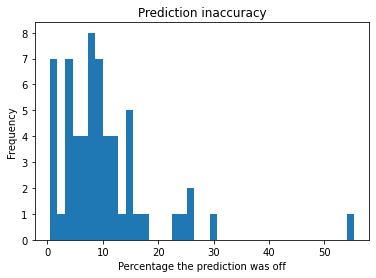

In [31]:
#Create dataframe with true rate and predicted rate and the difference between them.
#Use histogram to view how the individual predictions did
col_names = ['True_rate','RF_prediction']
results = pd.DataFrame([Y_test,rf_pred]).T
results.columns=col_names[0:2]
results['diff'] = abs(results['True_rate']-results['RF_prediction'])
results['percent'] = results['diff']/results['True_rate']*100
plt.hist(results['percent'],bins=40)
plt.title('Prediction inaccuracy')
plt.xlabel('Percentage the prediction was off')
plt.ylabel('Frequency')
plt.show()

In [32]:
#Get count of predictions > 15%
print('total predictions: ', len(results))
print('predictions off > 15%: ', len(results[results['percent']>15]))

total predictions:  60
predictions off > 15%:  9


In [202]:
#Full record of the worst prediction
biggest_miss = results['percent'].max()
print('biggest miss: ',round(biggest_miss,2),'%')
biggest_miss_idx = results[results['percent']==results['percent'].max()].index.values[0]
print('index: ',biggest_miss_idx)
print(test_data.loc[biggest_miss_idx,:])

biggest miss:  55.35 %
index:  6
Area Code                         E09000020
Area Name            Kensington and Chelsea
gen_warts                           97.5367
syphilis                             64.387
gonorrhea                           379.309
HIV                                 9.71101
herpes                              100.087
chlamydia                           561.633
TB                                  11.7505
comm_disease_flu                    7.56425
antibiotics                        0.457252
typhoid                            0.642092
measles                             8.34719
hepatitis                          0.642092
STEC                                1.92065
salmonella                          31.9028
campylobacter                       40.8356
giardia                             1.27611
cryptosporidium                           0
shigella                               5.74
listeria                           0.640217
mumps                               1.92065

In [204]:
#Full record of the best prediction
closest_pred = results['percent'].min()
print('closest prediction: ',round(closest_pred,2),'%')
closest_pred_idx = results[results['percent']==results['percent'].min()].index.values[0]
print('index: ',closest_pred_idx)
print(test_data.loc[closest_pred_idx,:])

closest prediction:  0.42 %
index:  56
Area Code                  E07000127
Area Name            West Lancashire
gen_warts                    23.5816
syphilis                     1.74679
gonorrhea                    26.2018
HIV                         0.600069
herpes                        28.822
chlamydia                    224.462
TB                          0.584563
comm_disease_flu             7.24606
antibiotics                 0.812529
typhoid                            0
measles                            0
hepatitis                          0
STEC                               0
salmonella                   5.29096
campylobacter                116.401
giardia                      11.4637
cryptosporidium              12.3456
shigella                        4.41
listeria                           0
mumps                         6.1431
pertusis                     7.02488
IMD                          1.75622
mental                       21.6112
noise                        4.92342